In [11]:
#IMPORTS

from functions import *
import nibabel as nib
from monai.networks.nets import UNet
import torch
import pathlib as p

In [12]:
# SPECIFY PARAMETERS

# data
patch_size = (32, 32, 32)
stride = (16, 16, 16)
target_shape = (192, 224, 192)

# network
spatial_dims=3
in_channels=2
out_channels=1
channels=(32, 64, 128, 256, 512, 1024)
net_strides=(2, 2, 2, 2, 2)
res_units=10
norm=None

# path to this repo
DATA_DIR = p.Path.home()/"data"/"bobsrepository"


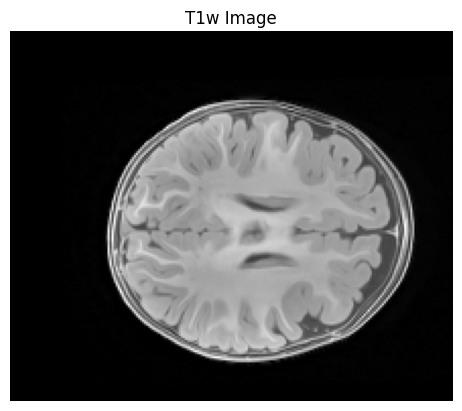

In [ ]:
#LOAD DATA

# Path to input images
t1 = "/Users/al1612le/data/bobsrepository/sub-890518/ses-8mo/anat/sub-890518_ses-8mo_space-INFANTMNIacpc_T1w.nii.gz" # isotropic t1w image
t2_lr = "/Users/al1612le/data/bobsrepository/LR_data/sub-890518_ses-8mo_space-INFANTMNIacpc_T2w_LR6.nii.gz" # anisotropic t2w image

# reassure correct shape and voxel size
assert nib.load(t1).shape == nib.load(t2_lr).shape == (182,218,182)
assert nib.load(t1).header.get_zooms() == nib.load(t2_lr).header.get_zooms() == (1.0,1.0,1.0)

In [29]:
# EXTRACT PATCHES

t1_patches, affine = get_patches_single_img(t1, patch_size, stride, target_shape)
t2_lr_patches, affine = get_patches_single_img(t2_lr, patch_size, stride, target_shape)

In [34]:
# LOAD NETWORK

DATA_DIR = p.Path.home()/"data"/"bobsrepository"

net = UNet(
    spatial_dims=3,
    in_channels=2,
    out_channels=1,
    channels=(32, 64, 128, 256, 512, 1024),
    strides=(2, 2, 2, 2, 2),
    num_res_units=10,
    norm=None,
)
net.load_state_dict(torch.load(DATA_DIR/"outputs"/"2025-12-01T09:47:31.531308_model_weights.pth", map_location="cpu"))

/var/folders/j3/fb9w9g7s1vqdx2y5by7m63180000gp/T/ipykernel_99893/1908555651.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(DATA_DIR/"out

<All keys matched successfully>

In [ ]:
# TEST NETWORK

all_outputs = []
net.eval()
with torch.no_grad():
    for i in range(len(t1_patches)):
        input1 = torch.tensor(t1_patches[i]).float()
        input2 = torch.tensor(t2_lr_patches[i]).float()
        inputs = torch.stack([input1, input2], dim=0) .unsqueeze(0)
        output = net(inputs)
        all_outputs.append(output.squeeze(0).squeeze(0).cpu().numpy()) 
    t2_reconstructed = reconstruct_from_patches(all_outputs, target_shape, stride)


In [36]:
# SAVE RECONSTRUCTED IMAGE

nib.save(nib.Nifti1Image(t2_reconstructed, affine), DATA_DIR/"demo_reconstructed_t2_maind6.nii.gz")